# ML Assignment 2 - Sample Code
* 雲端硬碟: https://drive.google.com/drive/folders/1Qhr6vo5zB3hdzpEZ8oG243FlVhLYfn4X?usp=sharing
* 蘭花競賽網站: https://tbrain.trendmicro.com.tw/Competitions/Details/20

## 執行方式
依作業要求，在圖像轉換或修改模型架構區塊更改程式碼，更改完成後，可以直接全部執行。
訓練過程及輸出位於最後面。


## 初始設定

In [23]:
!pip install --upgrade numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


記得修改cd路徑 這邊ai cup是我自訂的資料夾名稱，副檔會直接產生在colab notebooks下，所以將ai cup這個路徑去掉在執行

In [25]:
%cd /content/drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [26]:
#%matplotlib inline
#! ls
#! unzip -q training.zip -d ./

In [27]:
from __future__ import print_function, division

import time
import os
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.hub import load_state_dict_from_url
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.ion()   # interactive mode
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"

## 圖像轉換
### 題目
torchvision.transforms 提供了許多可靠的 API來讓使用者對圖像進行操作，請試著在 data_transforms 當中對訓練集進行轉換(圖像前處理)，當模型訓練到一定程度時，驗證看看使用該方法是否確實對模型準確率造成影響，然後試著解釋使用該轉換方法會對模型訓練產生什麼影響。

* 至少嘗試使用 **五種** 不同的圖像轉換方法，並且找出最佳的方法組合。(使用方法數量為加分bonus的依據)
* 須在報告中註明每一個方法 **在未使用時的準確率**、**使用後的準確率**，並 **說明該方法的目的** 及 **最終最佳組合的準確率**。

### 說明
請在註解區塊中寫入圖像轉換的方法。


In [28]:
from torchvision.transforms.transforms import RandomHorizontalFlip
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((224,224) ),
            ########在此區塊填入圖像轉換方法########
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.RandomPerspective(),
            ########################################
            transforms.ToTensor(),
        ]),
        'val': transforms.Compose([
            transforms.Resize((224,224) ),
            transforms.ToTensor(),
        ]),
    }
data_transforms

{'train': Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
     RandomHorizontalFlip(p=0.5)
     RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
     RandomPerspective(p=0.5)
     ToTensor()
 ), 'val': Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
     ToTensor()
 )}

## 修改模型架構
### 第一題 題目
在本次作業範例中我們使用了CNN來做為整個分類模型的架構。請以第一題中最佳的圖像轉換方法組合，並基於CNN架構增加或減少模型的隱藏層，並觀察修改模型後對原先準確率的影響(即修改模型的意思)

* 至少使用 **三種** 不同隱藏層或不同的修改模型方法(增加或減少模型的隱藏層，並且找出最佳的模型架構。(修改方法多寡為加分bonus的依據)
* 須在報告中註明每一個方法 **在更改前的準確率**、 **更改後的準確率** 及 **最終最佳模型架構的準確率**。

### 說明
* 因為模型有套用預訓練的參數，所以更改模型的方式比較複雜，

* 請勿直接更改現有隱藏層的參數(輸入、輸出大小等等)，請用增加或減少的方式來修改模型架構。

* 請注意並計算各隱藏層可接受的輸出入大小，以免產生資料維度前後層對不上的問題。


In [34]:
class MyCNN(nn.Module):

  def __init__(self, num_classes=1000):
    super(MyCNN, self).__init__()
    self.features = nn.Sequential(
      #============== 在此區塊新增或減少隱藏層 =================
      nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
      nn.ReLU(inplace=True),
      #nn.MaxPool2d(kernel_size=3, stride=2),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(64, 192, kernel_size=5, padding=2),
      nn.ReLU(inplace=True),
      #nn.MaxPool2d(kernel_size=3, stride=2),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(192, 384, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(384, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(256, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      #nn.MaxPool2d(kernel_size=3, stride=2),
      nn.MaxPool2d(kernel_size=2, stride=2),
      #============================================================
    )
    self.features2 = nn.Sequential(
      #============== 可在此區塊新增隱藏層 =====================
      
      #===========================================================
    )
    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
    self.classifier = nn.Sequential(
      #============== 在此區塊新增或減少隱藏層 =================
      nn.Dropout(),
      nn.Linear(256 * 6 * 6, 4096),
      nn.ReLU(inplace=True),
      nn.Dropout(),
      nn.Linear(4096, 4096),
      nn.ReLU(inplace=True),
      # nn.Linear(4096, num_classes), # 原始模型輸出層
      #===========================================================
    )
    self.classifier2 = nn.Sequential(
      #============== 可在此區塊新增隱藏層 =====================
      


      #===========================================================
      nn.Linear(4096, num_classes),
    )

  def forward(self, x):
    x = self.features(x)
    x = self.features2(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)

    x = self.classifier(x)
    x = self.classifier2(x)

    return x

## 訓練模型區塊
包含視覺化模型及訓練模型。

In [30]:
def visualize_model(model, device, dataloaders, class_names, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0

  plt.figure(figsize=(18,9))

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1

        img_display = np.transpose(inputs.cpu().data[j].numpy(), (1,2,0)) #numpy:CHW, PIL:HWC
        plt.subplot(num_images//2,2,images_so_far),plt.imshow(img_display) #nrow,ncol,image_idx
        plt.title(f'predicted: {class_names[preds[j]]}')
        plt.savefig("test.jpg")
        if images_so_far == num_images:
            model.train(mode=was_training)
            return
    model.train(mode=was_training)

def imshow(inp, title=None):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  
  #原先Normalize是對每個channel個別做 減去mean, 再除上std
  inp1 = std * inp + mean

  plt.imshow(inp)

  if title is not None:
      plt.title(title)
  plt.pause(0.001)  # pause a bit so that plots are updated
  plt.imshow(inp1)
  if title is not None:
      plt.title(title)


def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [31]:
def train_model(model, criterion, device, dataloaders, dataset_sizes, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  train_loss, valid_loss = [], []
  train_acc, valid_acc = [], []

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in tqdm(dataloaders[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            if phase == 'train':
                # zero the parameter gradients
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      if phase == 'train':
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
      else:
        valid_loss.append(epoch_loss)
        valid_acc.append(epoch_acc)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())


  plt.figure(0)
  plt.plot(range(1,num_epochs+1,1), np.array(train_loss), 'r-', label= "train loss") #relative global step
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.savefig(f"./train_loss.png")

  plt.figure(0)
  plt.plot(range(1,num_epochs+1,1), np.array(valid_loss), 'b-', label= "eval loss") #--evaluate_during_training True 在啟用eval
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.savefig(f"./eval_loss.png")

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  #torch.save(model.state_dict(),"model.pt")
  return model

## 訓練參數 (可調整)
* num_epochs: 訓練回合數
* lr: 訓練速度(learning rate)
* batch_size: 批次(batch)大小

In [32]:
num_epochs = 20
lr = 0.001
batch_size = 64

## 主函式

Using device cuda:0



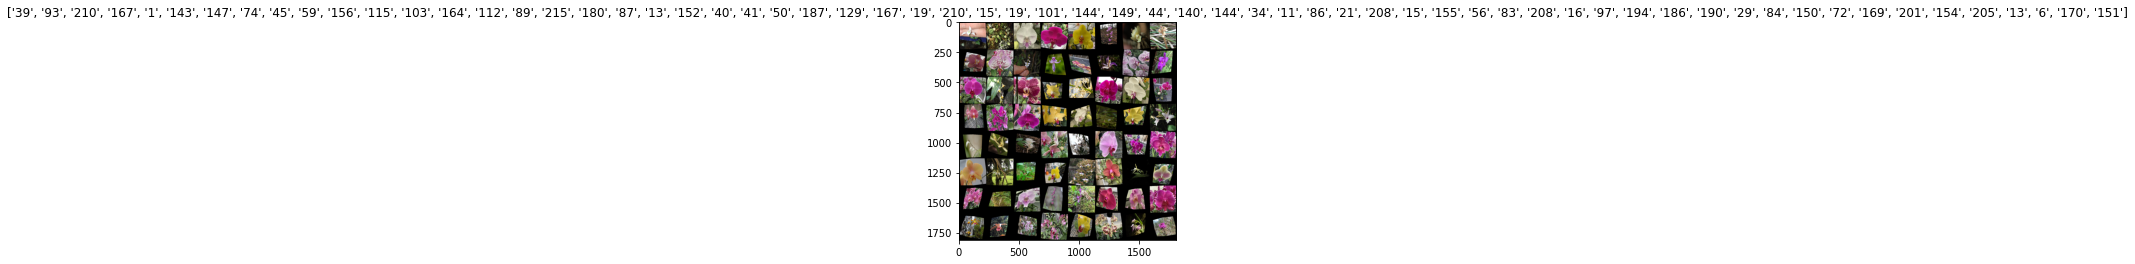

features.0.weight
features.0.bias
features.3.weight
features.3.bias
features.6.weight
features.6.bias
features.8.weight
features.8.bias
features.10.weight
features.10.bias
classifier.1.weight
classifier.1.bias
classifier.4.weight
classifier.4.bias
classifier2.0.weight
classifier2.0.bias
#parameters:57901083
batch_size:64
Epoch 1/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


train Loss: 5.4251 Acc: 0.0065


100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


val Loss: 5.2882 Acc: 0.0137
Epoch 2/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.85it/s]


train Loss: 5.2037 Acc: 0.0274


100%|██████████| 11/11 [00:04<00:00,  2.25it/s]


val Loss: 4.9892 Acc: 0.0609
Epoch 3/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


train Loss: 4.7646 Acc: 0.0581


100%|██████████| 11/11 [00:04<00:00,  2.33it/s]


val Loss: 4.1885 Acc: 0.1324
Epoch 4/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.91it/s]


train Loss: 3.8393 Acc: 0.1598


100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


val Loss: 3.3168 Acc: 0.2359
Epoch 5/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


train Loss: 3.0419 Acc: 0.2590


100%|██████████| 11/11 [00:05<00:00,  2.13it/s]


val Loss: 2.8445 Acc: 0.2831
Epoch 6/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.96it/s]


train Loss: 2.4778 Acc: 0.3568


100%|██████████| 11/11 [00:04<00:00,  2.30it/s]


val Loss: 2.4165 Acc: 0.3988
Epoch 7/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.92it/s]


train Loss: 2.0894 Acc: 0.4468


100%|██████████| 11/11 [00:04<00:00,  2.28it/s]


val Loss: 2.2132 Acc: 0.4125
Epoch 8/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.91it/s]


train Loss: 1.5028 Acc: 0.5956


100%|██████████| 11/11 [00:04<00:00,  2.29it/s]


val Loss: 2.0211 Acc: 0.4673
Epoch 9/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


train Loss: 1.2858 Acc: 0.6341


100%|██████████| 11/11 [00:04<00:00,  2.36it/s]


val Loss: 1.9278 Acc: 0.4840
Epoch 10/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.92it/s]


train Loss: 1.1872 Acc: 0.6588


100%|██████████| 11/11 [00:04<00:00,  2.27it/s]


val Loss: 1.9679 Acc: 0.4855
Epoch 11/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.92it/s]


train Loss: 1.1053 Acc: 0.6797


100%|██████████| 11/11 [00:04<00:00,  2.36it/s]


val Loss: 1.9720 Acc: 0.4947
Epoch 12/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.92it/s]


train Loss: 1.0799 Acc: 0.6849


100%|██████████| 11/11 [00:04<00:00,  2.30it/s]


val Loss: 1.9579 Acc: 0.5038
Epoch 13/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


train Loss: 1.0738 Acc: 0.6823


100%|██████████| 11/11 [00:04<00:00,  2.29it/s]


val Loss: 1.9507 Acc: 0.5205
Epoch 14/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.93it/s]


train Loss: 1.0469 Acc: 0.6882


100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


val Loss: 1.9588 Acc: 0.4901
Epoch 15/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.93it/s]


train Loss: 0.9547 Acc: 0.7208


100%|██████████| 11/11 [00:04<00:00,  2.31it/s]


val Loss: 1.9417 Acc: 0.5023
Epoch 16/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.89it/s]


train Loss: 0.9668 Acc: 0.7202


100%|██████████| 11/11 [00:04<00:00,  2.33it/s]


val Loss: 1.9316 Acc: 0.5068
Epoch 17/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.88it/s]


train Loss: 0.9376 Acc: 0.7286


100%|██████████| 11/11 [00:04<00:00,  2.29it/s]


val Loss: 1.9306 Acc: 0.5129
Epoch 18/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.93it/s]


train Loss: 0.9677 Acc: 0.7123


100%|██████████| 11/11 [00:04<00:00,  2.27it/s]


val Loss: 1.9298 Acc: 0.5099
Epoch 19/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.96it/s]


train Loss: 0.9173 Acc: 0.7293


100%|██████████| 11/11 [00:04<00:00,  2.30it/s]


val Loss: 1.9298 Acc: 0.5175
Epoch 20/20
----------


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


train Loss: 0.9220 Acc: 0.7293


100%|██████████| 11/11 [00:04<00:00,  2.32it/s]


val Loss: 1.9314 Acc: 0.5205
Training complete in 5m 46s
Best val Acc: 0.520548


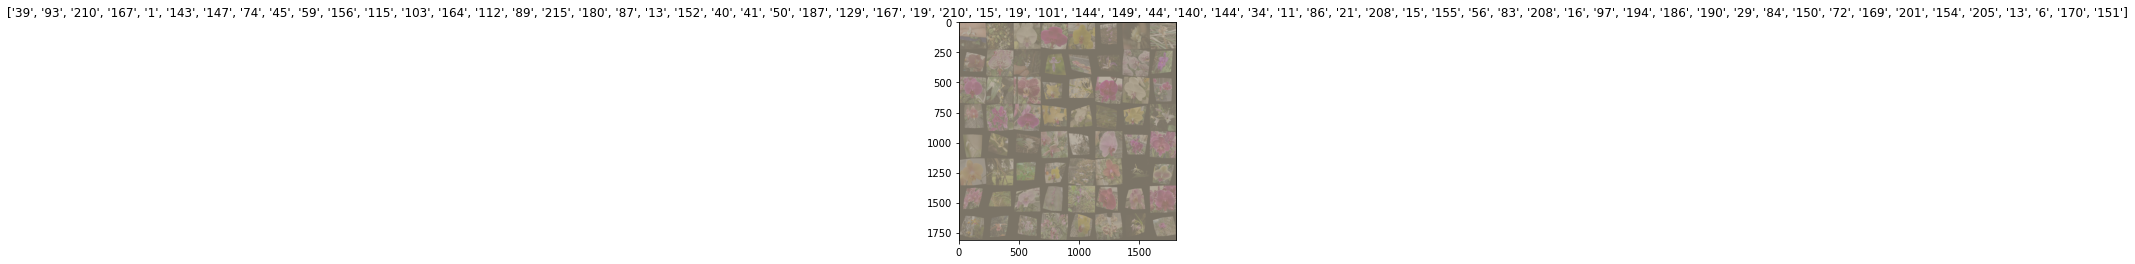

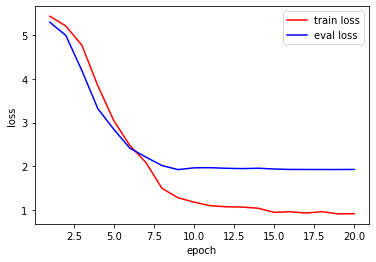

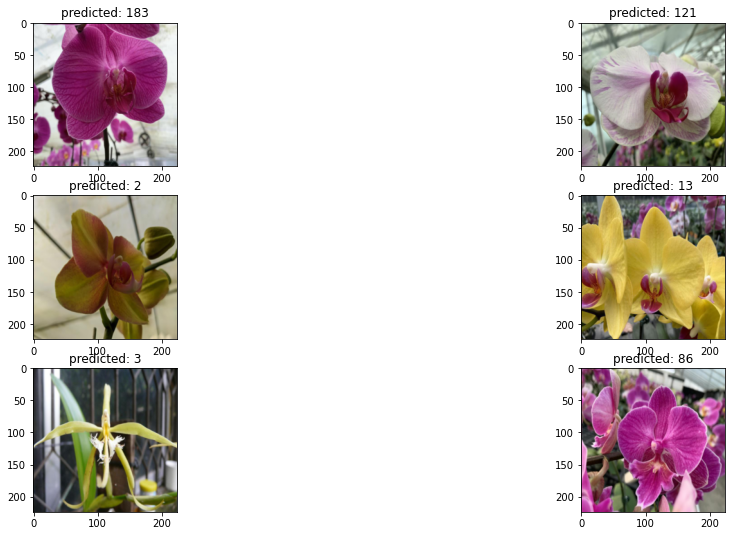

In [35]:
def main():
  num_workers = 2
  momentum = 0.9

  # 資料集載入 =======================================================================
  data_dir = './training'
  image_datasets = {
    x: datasets.ImageFolder(
      os.path.join(data_dir, x),
      data_transforms[x]
    ) 
    for x in ['train', 'val']
  }
  dataloaders = {
    x: torch.utils.data.DataLoader(
      image_datasets[x], 
      batch_size=batch_size,
      shuffle=True, 
      num_workers=num_workers
    )
    for x in ['train', 'val']
  }
  dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
  class_names = image_datasets['train'].classes
  # 資料集載入 =======================================================================

  # 設定 CUDA 環境 =======================================================================
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Using device {device}\n")
  # 設定 CUDA 環境 =======================================================================


  # Get a batch of training data
  inputs, classes = next(iter(dataloaders['train']))

  # Make a grid from batch
  out = torchvision.utils.make_grid(inputs)

  imshow(out, title=[class_names[x] for x in classes])

  
  # model =======================================================================
  model_ft = MyCNN(num_classes=219)
  pretrained_dict = load_state_dict_from_url(
    'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
    progress=True
  )
  model_dict = model_ft.state_dict()
  # 1. filter out unnecessary keys
  pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
  # 2. overwrite entries in the existing state dict
  model_dict.update(pretrained_dict) 
  # 3. load the new state dict
  model_ft.load_state_dict(model_dict)

  for k,v in model_dict.items():
    print(k)

  model_ft = model_ft.to(device)
  # model =======================================================================

  parameter_count = count_parameters(model_ft)
  print(f"#parameters:{parameter_count}")
  print(f"batch_size:{batch_size}")


  criterion = nn.CrossEntropyLoss()

  # Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum)

  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

  model_ft = train_model(
    model_ft, 
    criterion, 
    device, 
    dataloaders, 
    dataset_sizes, 
    optimizer_ft, 
    exp_lr_scheduler,     
    num_epochs=num_epochs
  )

  visualize_model(model_ft, device, dataloaders, class_names)

if __name__ == '__main__':
    main()